In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00


In [2]:
!python -m spacy download en_core_web_sm

/usr/bin/python3: No module named -q


In [3]:
import pathlib 
import warnings
import os
import io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

import tensorflow_text
import tensorflow as tf 
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [4]:
df = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Scammers send fake text messages to trick you into giving them your personal information – things like your password, account number, or Social Security number. If they get that information, they could gain access to your email, bank, or other accounts.

Spam Detection is a binary classification problem. The reason to do this is simple: by detecting unsolicited and unwanted messages, we can prevent spam messages from creeping into the user's inbox, thereby improving user experience.

In [5]:
df.groupby('v1').describe()

v2                                                                 \
     count unique                                                top freq   
v1                                                                          
ham   4825   4516                             Sorry, I'll call later   30   
spam   747    653  Please call our customer service representativ...    4   

     Unnamed: 2                                                            \
          count unique                                                top   
v1                                                                          
ham          45     39   bt not his girlfrnd... G o o d n i g h t . . .@"   
spam          5      4                                        PO Box 5249   

          Unnamed: 3                                    Unnamed: 4         \
     freq      count unique                    top freq      count unique   
v1                                                                          
ham     3         10      9                     GE    2          6      5   
spam    2          2      1   MK17 92H. 450Ppw 16"    2          0      0   

                    
          top freq  
v1                  
ham   GNT:-)"    2  
spam      NaN  NaN

In [6]:
df['length']=df['v2'].apply(len)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,length
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61


Let's drop those three unnamed columns as they won't bring much to our model building anyways.

In [7]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
df = df.rename(columns={'v1':'label','v2':'message'})

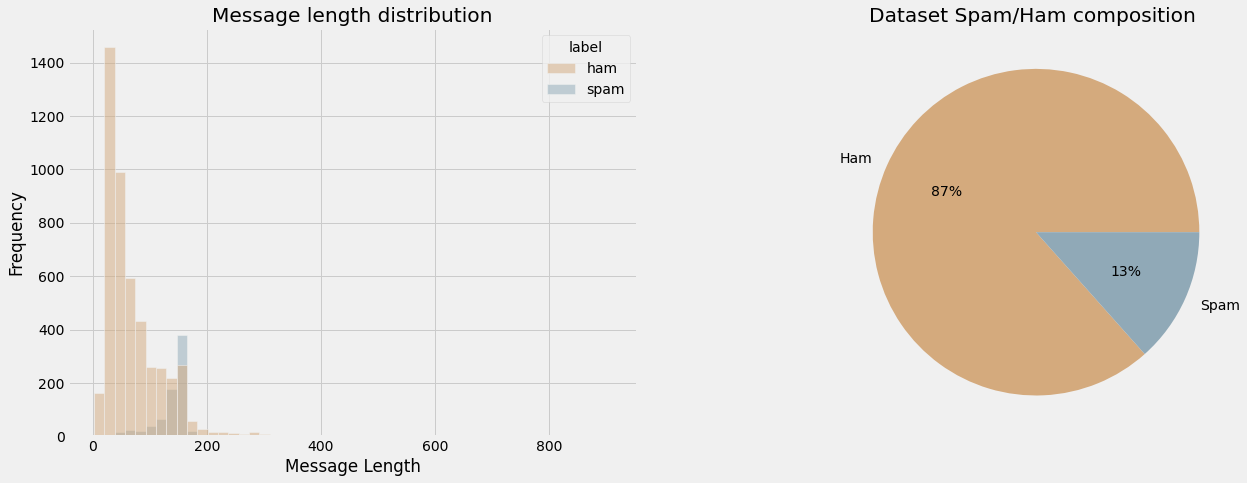

In [8]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
sns.histplot(data=df, x="length",
             hue="label",
             bins=50,
             ax=ax[0],
             palette=['#D4AA7D',"#90A9B7"],
             legend=True).set_title('Message length distribution')
ax[0].set_xlabel('Message Length')
ax[0].set_ylabel('Frequency')

ax[1].pie(df.label.value_counts(normalize=True), 
            labels = ['Ham','Spam'], 
            autopct='%0.f%%', 
            colors=['#D4AA7D',"#90A9B7"]
            )
ax[1].set_title('Dataset Spam/Ham composition ')
plt.show()

In [9]:
nlp = en_core_web_sm.load()

In [10]:
df['message_clean'] = df['message'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower().strip())
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [11]:
df['length_clean']=df['message_clean'].apply(len)
df.head()

,label,message,length,message_clean,length_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,131
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,18


In [12]:
df[df.label=='ham'].describe()

,length,length_clean
count,4825.000000,4825.000000
mean,71.023627,37.451192
std,58.016023,32.882734
min,2.000000,0.000000
25%,33.000000,17.000000
50%,52.000000,28.000000
75%,92.000000,48.000000
max,910.000000,455.000000


In [13]:
df[df.label=='spam'].describe()

,length,length_clean
count,747.000000,747.000000
mean,138.866131,98.353414
std,29.183082,25.652783
min,13.000000,12.000000
25%,132.500000,86.000000
50%,149.000000,102.000000
75%,157.000000,116.000000
max,224.000000,151.000000


In [14]:
df[df.length == 224].message.iloc[0]

'Good afternoon on this glorious anniversary day, my sweet J !! I hope this finds you happy and content, my Prey. I think of you and send a teasing kiss from across the sea coaxing images of fond souveniers ... You Cougar-Pen'

In [15]:
df[df.length_clean == 455].message_clean.iloc[0]

'girl happy difficult girl happy u need 1 friend 2 companion 3 lover 4 chef      ltgt   good listener   ltgt   organizer   ltgt   good boyfriend   ltgt   clean   ltgt   sympathetic   ltgt   athletic   ltgt   warm      ltgt   courageous   ltgt   determine   ltgt   true   ltgt   dependable   ltgt   intelligent      ltgt   psychologist   ltgt   p exterminator   ltgt   psychiatrist   ltgt   healer     ltgt   stylist   ltgt   driver    aaniye pudunga venaam'

In [16]:
df_ham  = df[df['label'] == 'ham'].copy()
df_spam = df[df['label'] == 'spam'].copy()

In [17]:
from wordcloud import WordCloud

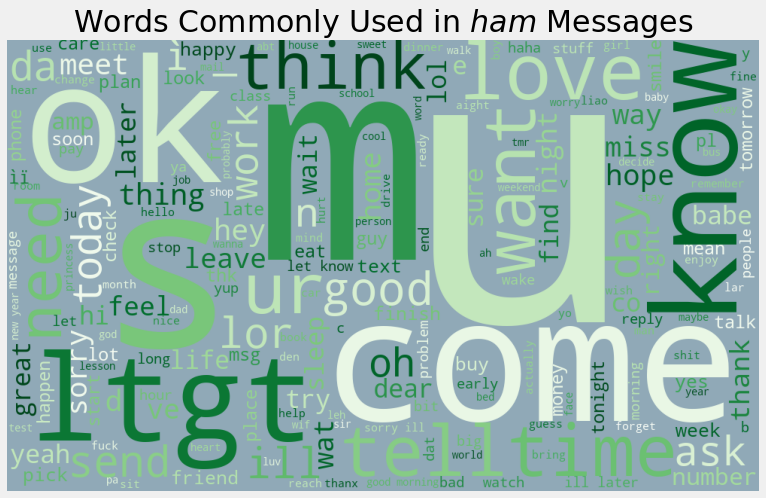

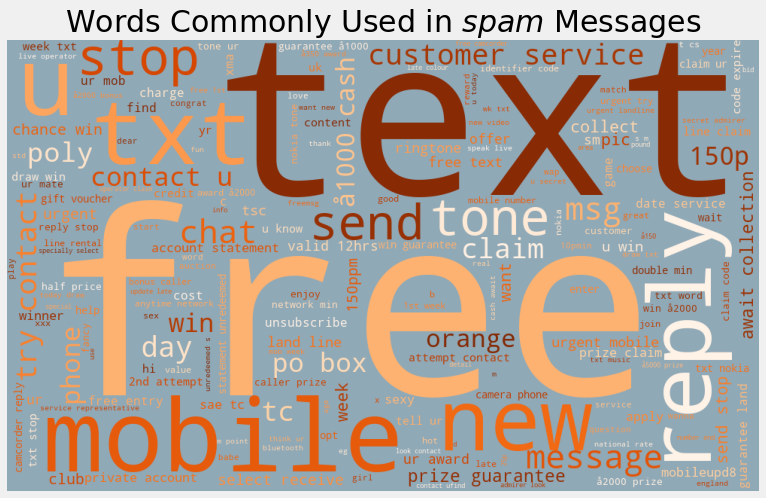

In [18]:
for label, cmap in zip(["ham", "spam"], ["Greens","Oranges"]):
    text = df.query("label == @label")["message_clean"].str.cat(sep=" ")
    plt.figure(figsize=(12, 8))
    wc = WordCloud(width=1000, height=600, background_color="#90A9B7", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=30)
    plt.show()

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" alt="Precision & Recall"/>
</p>

---

In [19]:
nlp = en_core_web_sm.load()

In [20]:
for token in nlp(df['message_clean'][0]) : 
  print(token.lemma_) 

jurong
point
crazy
available
bugis
n
great
world
la
e
buffet
cine
amore
wat


In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df.message_clean)

df["message_enc"] = tokenizer.texts_to_sequences(df.message_clean)
df["category"] = df["label"].apply(lambda x: 1 if x=="spam" else 0)
df.head()

,label,message,length,message_clean,length_clean,message_enc,category
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,75,"[1, 231, 445, 461, 944, 36, 52, 205, 945, 80, ...",0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,23,"[10, 194, 1, 290, 2, 1]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,131,"[12, 302, 4, 534, 656, 34, 1, 850, 421, 1, 1, ...",1
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,19,"[2, 125, 150, 1, 2, 85]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,18,"[707, 23, 657, 128]",0


In [22]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(df.message_enc, padding="post")

In [23]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,df.category, test_size=0.2)

In [24]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [25]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [26]:
for sms, categ in train_batch.take(1):
  print(sms, categ)

tf.Tensor(
[[ 41  39   0 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [100 688 599 ...   0   0   0]
 ...
 [ 19   6   0 ...   0   0   0]
 [ 68  14 391 ...   0   0   0]
 [365  17  54 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0], shape=(64,), dtype=int64)


In [27]:
sms.shape[1]

72

In [28]:
vocab_size = tokenizer.num_words

In [29]:
model_1 = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[sms.shape[1]],name="embedding"),
                  tf.keras.layers.GlobalMaxPooling1D(),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
                            ])

In [30]:
optimizer= tf.keras.optimizers.Adam()

model_1.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy
              ()])

In [31]:
history = model_1.fit(train_batch, epochs=50, validation_data=val_batch, batch_size=64)

Epoch 1/50
70/70 [==============================] - 13s 117ms/step - loss: 0.6346 - binary_accuracy: 0.8373 - val_loss: 0.5734 - val_binary_accuracy: 0.8556
Epoch 2/50
70/70 [==============================] - 4s 56ms/step - loss: 0.4974 - binary_accuracy: 0.8685 - val_loss: 0.4436 - val_binary_accuracy: 0.8556
Epoch 3/50
70/70 [==============================] - 3s 34ms/step - loss: 0.4020 - binary_accuracy: 0.8685 - val_loss: 0.4120 - val_binary_accuracy: 0.8556
Epoch 4/50
70/70 [==============================] - 1s 20ms/step - loss: 0.3880 - binary_accuracy: 0.8685 - val_loss: 0.4107 - val_binary_accuracy: 0.8556
Epoch 5/50
70/70 [==============================] - 1s 15ms/step - loss: 0.3863 - binary_accuracy: 0.8685 - val_loss: 0.4091 - val_binary_accuracy: 0.8556
Epoch 6/50
70/70 [==============================] - 1s 12ms/step - loss: 0.3842 - binary_accuracy: 0.8685 - val_loss: 0.4048 - val_binary_accuracy: 0.8556
Epoch 7/50
70/70 [==============================] - 1s 9ms/step - lo

In [1]:
color_chart = ["#D4AA7D", "#EFD09E", "#90A9B7", "D2D8B3"]


fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accruracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

NameError: ignored

In [33]:
# Use the model to predict whether a message is spam
messages_received = ['Greg, can you call me back once you get this?',
                      'Congrats on your new iPhone! Click here to claim your prize...', 
                      'Really like that new photo of you',
                      'Did you hear the news today? Terrible what has happened...',
                      'Attend this free COVID webinar today: Book your session now...']


# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(messages_received)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=72)           

fakes_prediction = model_1.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(messages_received)):
  print(messages_received[x])
  print(fakes_prediction[x])
  print('\n')

1/1 [==============================] - 0s 88ms/step
Greg, can you call me back once you get this?
[0.00856871]


Congrats on your new iPhone! Click here to claim your prize...
[0.9948775]


Really like that new photo of you
[0.91123897]


Did you hear the news today? Terrible what has happened...
[0.8887159]


Attend this free COVID webinar today: Book your session now...
[0.01691915]




# Transfer Learning : BERT Model

In [34]:
text_test = [df.message_clean[5]]

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
text_preprocessed = bert_preprocessor(text_test)

In [35]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [36]:
model_tlbert = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [37]:
model_tlbert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [38]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model_tlbert.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [39]:
# Train test split per text 
text_train, text_test, y_train, y_test = train_test_split(df.message_clean, df.category, test_size=0.1, random_state=1,stratify=df.category)

text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.1, random_state=1,stratify=y_train)

# creating tensorflow datasets slices and making batches

text_train_ds = tf.data.Dataset.from_tensor_slices((text_train, y_train))
text_test_ds = tf.data.Dataset.from_tensor_slices((text_test, y_test))
text_val_ds = tf.data.Dataset.from_tensor_slices((text_val, y_val))

text_train_ds = text_train_ds.shuffle(len(text_train_ds)).batch(64)
text_test_ds = text_test_ds.shuffle(len(text_test_ds)).batch(64)
text_val_ds = text_val_ds.shuffle(len(text_val_ds)).batch(64)

In [40]:
history_tlbert = model_tlbert.fit(text_train_ds, epochs=50, validation_data=text_val_ds)

Epoch 1/50
71/71 [==============================] - 26s 216ms/step - loss: 0.3866 - accuracy: 0.8497 - precision: 0.0989 - recall: 0.0149 - val_loss: 0.3144 - val_accuracy: 0.8665 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
71/71 [==============================] - 14s 202ms/step - loss: 0.2935 - accuracy: 0.8699 - precision: 0.9091 - recall: 0.0331 - val_loss: 0.2529 - val_accuracy: 0.8725 - val_precision: 1.0000 - val_recall: 0.0448
Epoch 3/50
71/71 [==============================] - 14s 200ms/step - loss: 0.2431 - accuracy: 0.8912 - precision: 0.8904 - recall: 0.2149 - val_loss: 0.2155 - val_accuracy: 0.9004 - val_precision: 1.0000 - val_recall: 0.2537
Epoch 4/50
71/71 [==============================] - 14s 203ms/step - loss: 0.2171 - accuracy: 0.9100 - precision: 0.8996 - recall: 0.3702 - val_loss: 0.1941 - val_accuracy: 0.9382 - val_precision: 0.8600 - val_recall: 0.6418
Epoch 5/50
71/71 [==============================] - 14s 201ms/step - loss: 0.1945 - accuracy

In [41]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_tlbert.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                          color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_tlbert.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
                      ])
fig.update_layout(
                  title='Training and val loss across epochs',
                  xaxis_title='epochs',
                  yaxis_title='Cross Entropy'    
                  )
fig.show()

In [42]:
# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(messages_received)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=72)           

fakes_prediction = model_tlbert.predict(text_val_ds)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(messages_received)):
  print(messages_received[x])
  print(fakes_prediction[x])
  print('\n')

8/8 [==============================] - 2s 175ms/step
Greg, can you call me back once you get this?
[0.00387095]


Congrats on your new iPhone! Click here to claim your prize...
[0.04887202]


Really like that new photo of you
[0.19277617]


Did you hear the news today? Terrible what has happened...
[0.00912913]


Attend this free COVID webinar today: Book your session now...
[0.30479404]




## Performance Benchmark
Let's compare the different models' performances by looking at the accuracy and F1-score

In [43]:
def performance_model(model, X, y):

    y_pred = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
  
    model_performance = {'accuracy': accuracy,
                          'f1-score': f1,
                         'precision': precision}
  
    return model_performance

In [44]:
simple_model = performance_model(model_1,xval, yval)
BERT_model = performance_model(model_tlbert,text_val, y_val)
  
data_results = pd.DataFrame({'Sequential Simple Model':simple_model,
                              'BERT-Transfer learning Model':BERT_model}).transpose()
                             
data_results.iloc[:,:3]

16/16 [==============================] - 2s 65ms/step


,accuracy,f1-score,precision
Sequential Simple Model,0.972197,0.903427,0.906250
BERT-Transfer learning Model,0.976096,0.910448,0.910448
